# PyTorch Workflow



1. data (prepare and load)
2. build model
3. fitting the modle to data (training)
4. making predictions and evaluating model (inference)
5. save e reload trained model
6. putting it all together



In [ ]:
import torch
from torch import nn # nn contains all building blocks for neural network
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

### Data (preparing and loading)
Data can be almost everything... in machine learning.
* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numberical rapresentation.
2. Build model to learn patterns in that numerical rapresentation

To showcase this, let's create some *known* data using the linear regression formula -> `Y=aX + b`

We'll use a linea regression formula to make a straight line with *known* **parameters** (a, b)

In [ ]:
# known parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X[:10], y[:10], len(X), len(y), X.shape)

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]]) 50 50 torch.Size([50, 1])


### Splitting data into training and test sets

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


How might we better visualize our data?

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # Plot train data in blue
  plt.scatter(train_data, train_labels, c="b", s=10, label="Training data")

  # Plot train data in green
  plt.scatter(test_data, test_labels, c="g", s=10, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", label="Predictions")

  # Show label
  plt.legend(prop={"size":14})
  plt.title("Model Prediction Visualization")
  plt.xlabel("Input Features (X)")
  plt.ylabel("Target Labels (y)")

  plt.show()

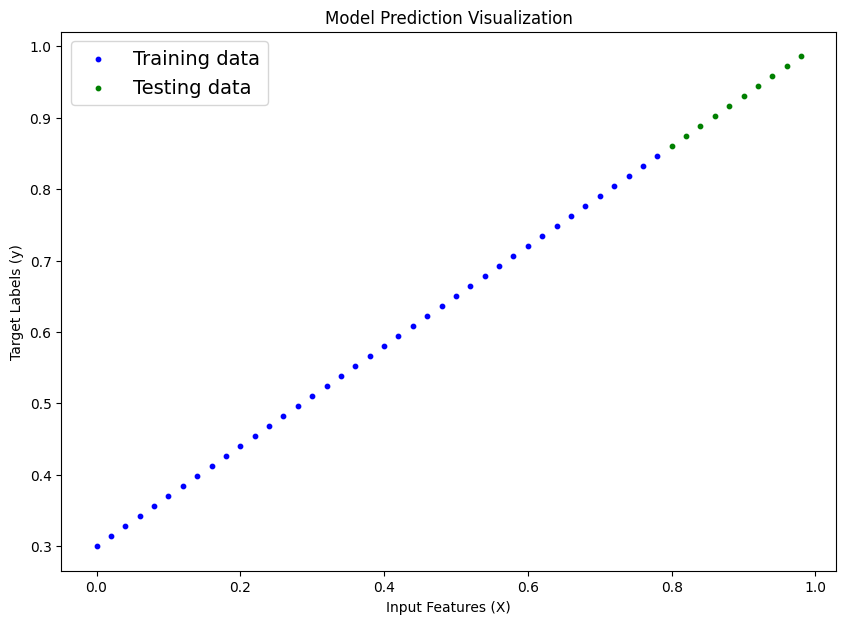

In [ ]:
plot_predictions()

## 2. Build model
What our model does:
* Start with random values (weight & bias)
* Look at the training data and adjust random values to better represent the ideal values (we know them for the exercise)

How does it do so?

Two main algorithms:
1. Gradient descent
2. Backpropagation

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inheritates from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # can this parameter updated via gradient descent?
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias


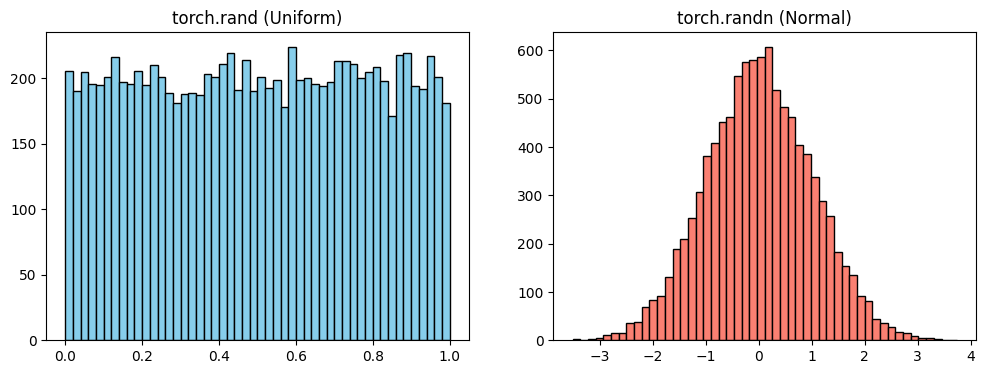

In [ ]:
# Difference between rand and randn

import torch
import matplotlib.pyplot as plt

# Generate 10,000 samples
uniform_data = torch.rand(10000)
normal_data = torch.randn(10000)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(uniform_data, bins=50, color='skyblue', edgecolor='black')
ax1.set_title("torch.rand (Uniform)")

ax2.hist(normal_data, bins=50, color='salmon', edgecolor='black')
ax2.set_title("torch.randn (Normal)")

plt.show()

### PyTorch model building essentials
* torch.nn - contains all of the buildings for computational graphs (neural network).
* torch.nn.Paramets - what parameters should our model try and learn, often a PyTprch layer from torch.nn will set these for us.
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward().
* torch.optim - where the optimizers in PyTorch live, they will help with gradient descent
* forward() - All nn.Module subclasses require to overwrite this method. It defines what happens in the forward computation

### Checking the contents of our model

In [ ]:
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# parameters
print(list(model_0.parameters()))

# list named parameters
print(model_0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})


### Making prediction using `torcg.inference_mode()`
To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.
When we pass data to the model, it runs data through the `forward()` method.

prediction: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]]).
 real value: tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])


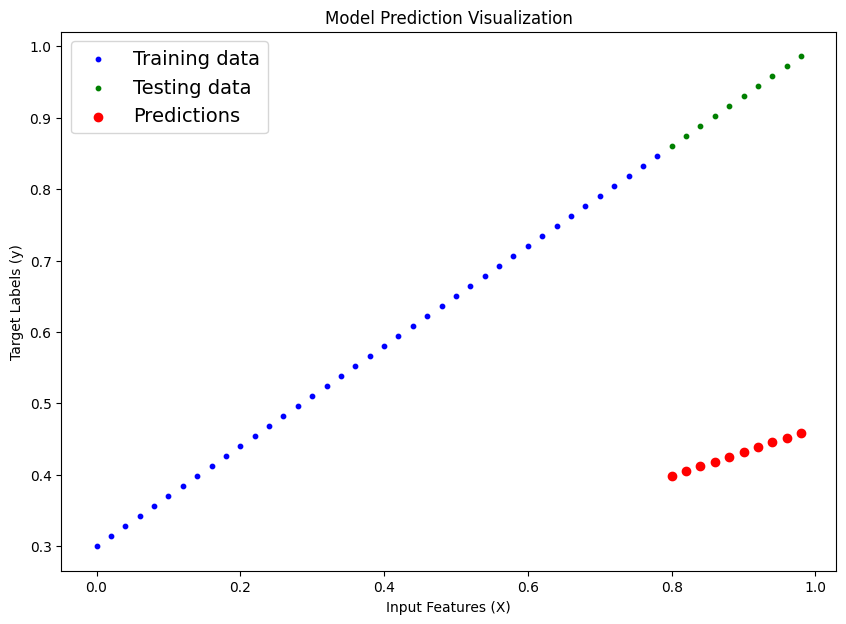

In [ ]:
# Make prediction
with torch.inference_mode(): # turns off gradient tracking for performance, we just need a prediction not training for now
  y_preds = model_0(X_test)

print(f'prediction: {y_preds}.\n real value: {y_test}')
plot_predictions(predictions=y_preds)
# as now it's not good with initial random weight and bias

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameters to some *known* parameters.
Or in other words from a poor representation of the data to a better representation. (check plot)

One way to measure how poor the model predictions are is using a loss method or cost function or criterion.

Things we need to train:

*   **Loss function:** a function to measure how wrong the model's predictions are to the ideal outputs, lower is better.
*   **Optimizer:** takes into account the loss of a model and adjusts the model's parameters to improve the loss function.

And specifically for PyTorch, we need:


*   A training loop
*   A testing loop

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

print(loss_fn)

# Setup an optimizer
## stochastic gradient descent
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # learning rate = possibly the most important hyperparameter that can be set ->
                                      # higher it is, bigger is the change of the parameters with each step

print(optimizer)

L1Loss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Building a training loop and a testing loop.

We need:


0.   Loop through the data
1.   Forward pass, this involves the data moving through the model `forward()` functions to make predictions on data - forward propagation
2. Calculate the loss (predictions compared to the truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss - backpropagation
5. Optimizer step - use the optimizer to adjust the model's parameters to improve the loss (gradient descent)




real weight and bias: 0.7, 0.3
Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.

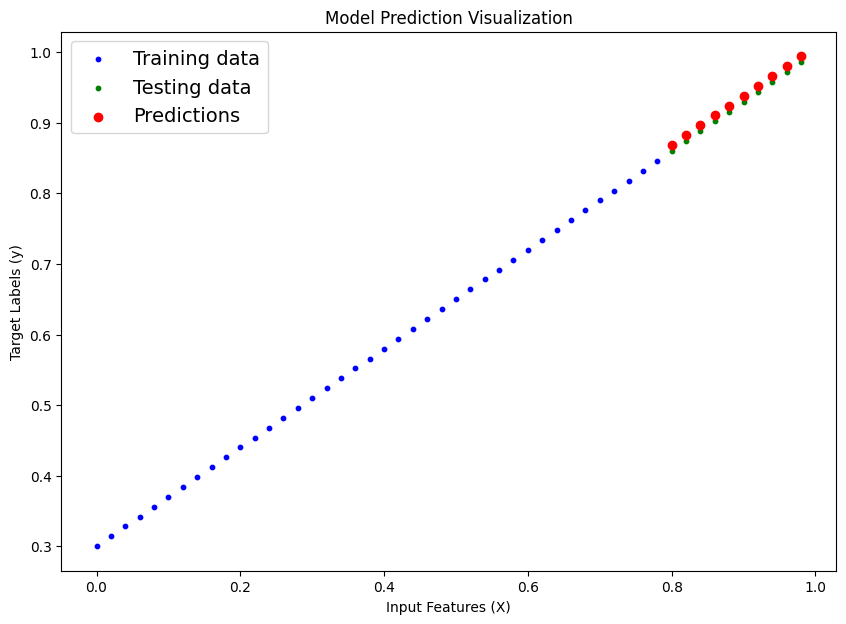

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 200 # another hyperparameter

# Track the training
epoch_count = []
loss_values = []
test_loss_values = []

print(f'real weight and bias: {weight}, {bias}')

### Training
# 0. loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # sets all parameters that require gredient to true

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step() # by default how the optimizer changes will accumulate through the loop, so we have to zero them in step 3 for the next loop


  ### Testing
  model_0.eval() # turns off different settings in the model not needed (dropout/batch norm layer)
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
    print(model_0.state_dict())

with torch.inference_mode():
  y_preds_new = model_0(X_test)
  plot_predictions(predictions=y_preds_new)


[tensor(0.4811), tensor(0.3464), tensor(0.2173), tensor(0.1446), tensor(0.1136), tensor(0.0992), tensor(0.0889), tensor(0.0806), tensor(0.0723), tensor(0.0647), tensor(0.0565), tensor(0.0482), tensor(0.0406), tensor(0.0323), tensor(0.0241), tensor(0.0165), tensor(0.0082), tensor(0.0050), tensor(0.0050), tensor(0.0050)]


/tmp/ipython-input-438193785.py:3: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")


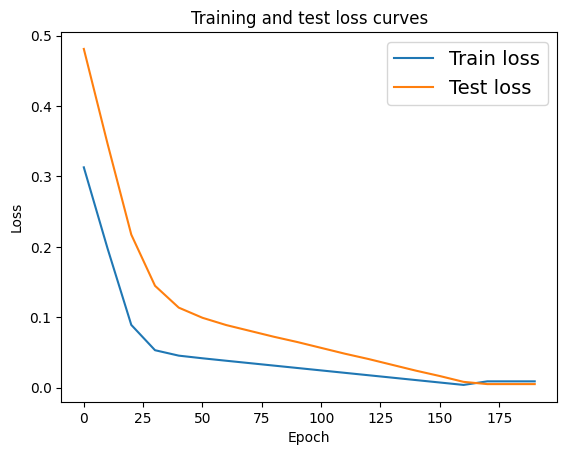

In [ ]:
print(test_loss_values)
# Plot the loss curves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss") # not need conversion to numpy because it has no gradient and matplot can convert it automatically
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(prop={"size":14})

## Saving a model in PyTorch

There are three main methods for saving and loading models in PyTorch.


1.   `torch.save()` - allows saving a PyTorch object in pickle format (python serialization)
2.   `torch.load()` - allows load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary



In [ ]:
# Saving model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(MODEL_SAVE_PATH)

# 3. Save state_dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)
print(f'Saved model to: {MODEL_SAVE_PATH}')

models/01_pytorch_workflow_model_0.pt
Saving model to: models/01_pytorch_workflow_model_0.pt
Saved model to: models/01_pytorch_workflow_model_0.pt


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 2117 Jan  2 19:14 01_pytorch_workflow_model_0.pt


## Loading Model

Since we saved only the state of the model rather the entire model, we'll create a new instance of model class and load states into it.

In [ ]:
model_load_0 = LinearRegressionModel()
# 1. Register your custom class
torch.serialization.add_safe_globals([LinearRegressionModel])

# 2. load the model
print(f'Initial model params: {model_load_0.state_dict()}')
print(f'Saved model params: {model_0.state_dict()}')
model_load_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model_load_0.eval()
print(f'Loaded model params: {model_load_0.state_dict()}')

# Make some predictions with loaded model
with torch.inference_mode():
  y_preds = model_0(X_test)
  loaded_model_preds = model_load_0(X_test)

print(y_preds == loaded_model_preds)

Initial model params: OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})
Saved model params: OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loaded model params: OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


## 6. Putting all together
Let's go back through the steps above

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

Using device: cuda


### 6.1 Data

40 40 10 10


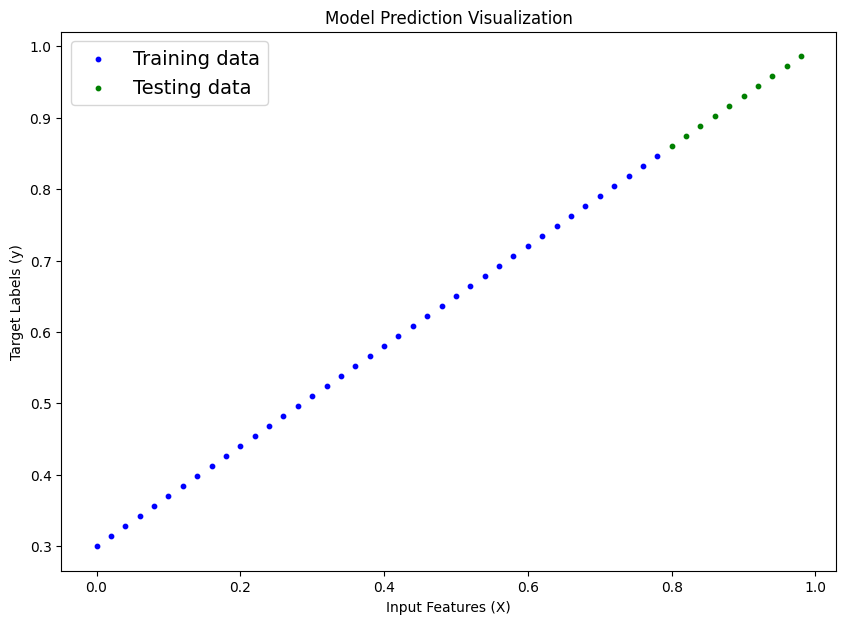

In [ ]:
# Create some data using the linear regression formula
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# Split Data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

# Plot data
plot_predictions()

### 6.2 Buidling a Linear Model

In [ ]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating model parameters. Also called linear transform, connected layer...
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
print(model_1, model_1.state_dict())

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
) OrderedDict({'linear_layer.weight': tensor([[0.7645]]), 'linear_layer.bias': tensor([0.8300])})


In [ ]:
# Set the model to use the target device
model_1.to(device)
print(next(model_1.parameters()).device)

cuda:0


### 6.3 Training

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(lr=0.01, params=model_1.parameters())

# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Compute loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
    print(model_1.state_dict())


Epoch: 0 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
OrderedDict({'linear_layer.weight': tensor([[0.6929]], device='cuda:0'), 'linear_layer.bias': tensor([0.2925], device='cuda:0')})
Epoch: 10 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
OrderedDict({'linear_layer.weight': tensor([[0.6929]], device='cuda:0'), 'linear_layer.bias': tensor([0.2925], device='cuda:0')})
Epoch: 20 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
OrderedDict({'linear_layer.weight': tensor([[0.6929]], device='cuda:0'), 'linear_layer.bias': tensor([0.2925], device='cuda:0')})
Epoch: 30 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
OrderedDict({'linear_layer.weight': tensor([[0.6929]], device='cuda:0'), 'linear_layer.bias': tensor([0.2925], device='cuda:0')})
Epoch: 40 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
OrderedDict({'linear_layer.weight': tensor([[0.6929]], device='cuda:0'), 'linear_layer.bias': tensor([0.2925], 

### 6.4 Making and evaluating predictions

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')


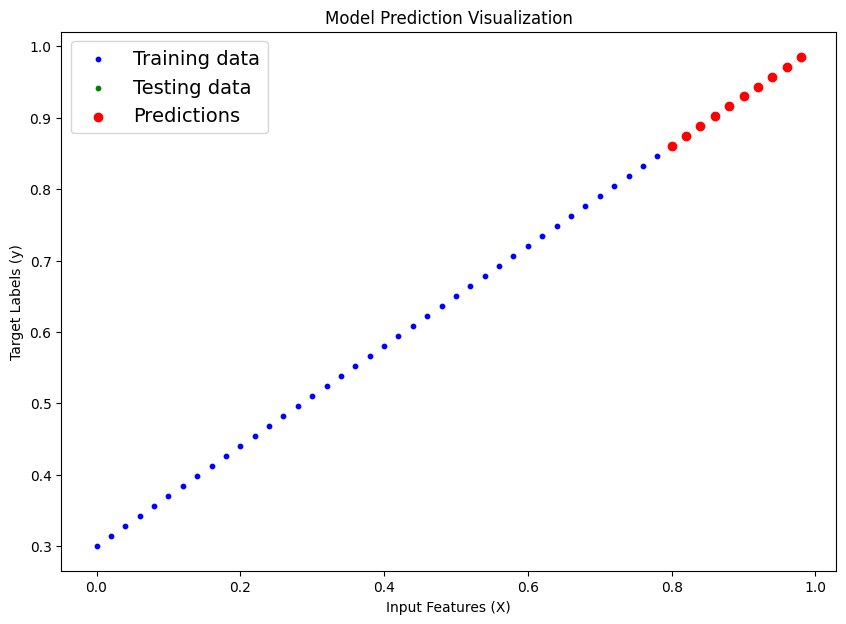

In [ ]:
model_1.eval()

with torch.inference_mode():
  y_preds_new = model_1(X_test)
  print(y_preds_new)
  plot_predictions(predictions=y_preds_new.cpu())

### 6.5 Saving & loading a trained model

In [ ]:
# Saving model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(MODEL_SAVE_PATH)

# 3. Save state_dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(model_1.state_dict(), MODEL_SAVE_PATH)
print(f'Saved model to: {MODEL_SAVE_PATH}')

## loading
model_load_1 = LinearRegressionModelV2().to(device)
# 1. Register your custom class
torch.serialization.add_safe_globals([LinearRegressionModelV2])

# 2. load the model
print(f'Initial model params: {model_load_1.state_dict()}')
print(f'Saved model params: {model_1.state_dict()}')
model_load_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model_load_1.eval()
print(f'Loaded model params: {model_load_0.state_dict()}')

# Make some predictions with loaded model
with torch.inference_mode():
  y_preds = model_1(X_test)
  loaded_model_preds = model_load_1(X_test)

print(y_preds == loaded_model_preds)

models/01_pytorch_workflow_model_1.pt
Saving model to: models/01_pytorch_workflow_model_1.pt
Saved model to: models/01_pytorch_workflow_model_1.pt
Initial model params: OrderedDict({'linear_layer.weight': tensor([[-0.2343]], device='cuda:0'), 'linear_layer.bias': tensor([0.9186], device='cuda:0')})
Saved model params: OrderedDict({'linear_layer.weight': tensor([[0.6968]], device='cuda:0'), 'linear_layer.bias': tensor([0.3025], device='cuda:0')})
Loaded model params: OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')
